In [40]:
import sys
sys.path.append('/Users/liushuhan/Documents/AL_GNN/Experiments/RSP/Sythentic_graph')
sys.path.append('../')

from loss import *
from solver import *
from Generator import *

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sb

/Users/liushuhan/Documents/AL_GNN/Experiments/RSP/Sythentic_graph/Generator.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_mean = torch.tensor(group_mean[group_label[i],])


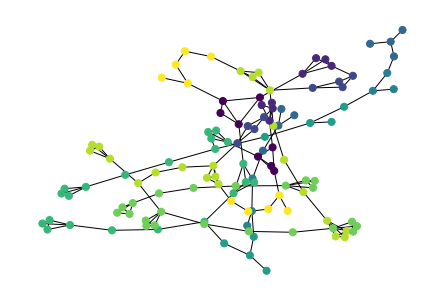

In [41]:
list_shapes = ['nx.diamond_graph'] * 3
list_shapes_args = [[]] * 3
list_shapes += ['nx.star_graph'] * 3
list_shapes_args += [[3], [2], [3]]
list_shapes += ['nx.barbell_graph'] * 3
list_shapes_args += [[4,3]] * 3
list_shapes += ['nx.path_graph'] 
list_shapes_args += [[5]]

graph_type = 'nx.connected_watts_strogatz_graph'
graph_args = [10, 2, 0.4]
G, Gg, group_label, shape_label, shape_dist = synthetic_graph_generator(list_shapes, list_shapes_args, graph_type, graph_args, plot=True, plot_color = 'group_label', savefig=False)
node_features, group_mean = synthetic_feature_generator(group_label, num_features=20, std=0.5)
node_features = node_features.numpy()
group_mean = group_mean.numpy()
# Draw
nx.draw(G, node_color=group_label, node_size=50)
# Get Laplacian, Gamma
L = np.float32(nx.laplacian_matrix(G).todense())
Gamma = np.float32(nx.incidence_matrix(G).todense().T) # E * N
for i in range(Gamma.shape[0]):
    for j in range(Gamma.shape[1]):
        if Gamma[i,j] !=0:
            Gamma[i,j] = - Gamma[i,j]
            break

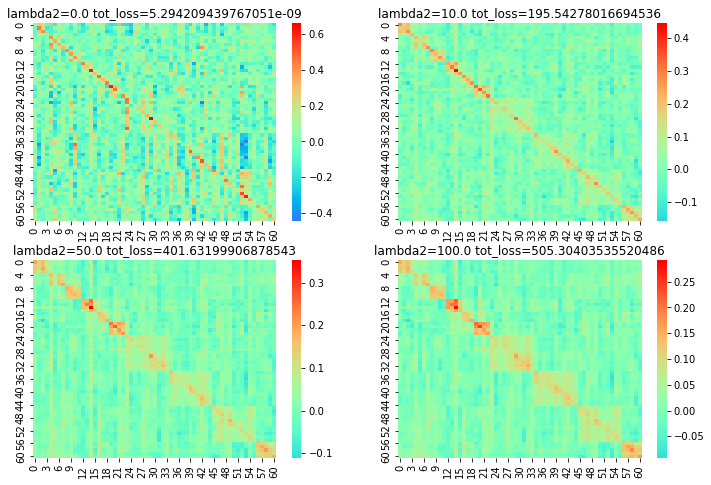

In [42]:
# the optimal W when there is no constraint
l2s = np.float32([0, 10, 50, 100])
num = len(l2s)

f = plt.figure(figsize=(12,8))
for i in range(num):
    ax0 = f.add_subplot(eval('22'+str(i+1)))
    W = lap_sylvester_solver(X=node_features, L=L, l2=l2s[i])
    sb.heatmap(W, cmap='rainbow', center=0)
    loss = recon_loss(X=node_features, W=W).value + compute_lap_penalty(L=L, W=W, l2=l2s[i])
    ax0.set_title('lambda2='+str(l2s[i])+' '+'tot_loss='+str(loss))

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

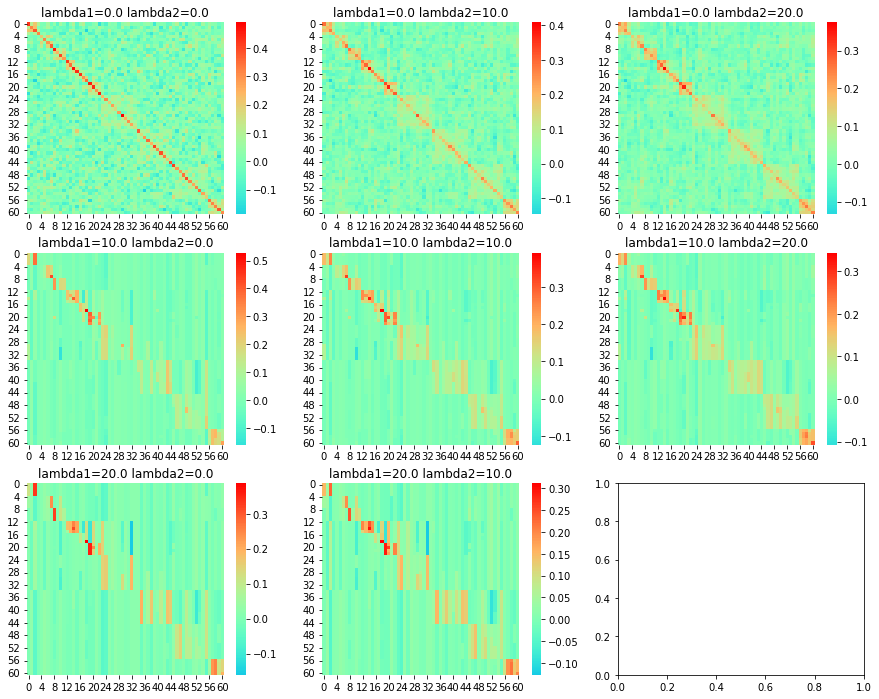

In [44]:
# the optimal W when there is no constraint
l1s = np.float32([0, 10, 20])
l2s = np.float32([0, 10, 20])
num1 = len(l1s)
num2 = len(l2s)

f = plt.figure(figsize=(15,12))
for i in range(num1):
    for j in range(num2):
        ax0 = f.add_subplot(eval('33'+str(i*3+j+1)))
        ax0.set_axis_off
        W = elast_cp_solver(X=node_features, Gamma=Gamma, l1=l1s[i], l2=l2s[j], maxiter=50)
        sb.heatmap(W, cmap='rainbow', center=0)
        loss = recon_loss(X=node_features, W=W).value + ee_penalty(Gamma, W, l1=l1s[i], l2=l2s[j]).value
        ax0.set_title('lambda1='+str(l1s[i])+' '+'lambda2='+str(l2s[j]))